# Model Analyses and Interpretation

So far, I have trained two machined learning models to explain the impact of access to transit on the proportion of residents using public transportation, down to the DA level. I also tuned their hyperparameters using cross validation. They have both achieved cross-validation $R^2$ at about 0.67. 

However, there is still a big distance between our models and actionable real-world solutions. At the end of the day, we want to know where the transit authority of Greater Vancouver Area should put resource to develop new infrastructure. 

In [1]:
import geopandas
import json
import joblib
import os
import pandas as pd

In [2]:
# sklearn modules
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
)

In [3]:
# Mapping modules
import contextily as ctx
import matplotlib.pyplot as plt

GVA_map_xlim_lower = -13746072.435927173
GVA_map_xlim_higher = -13630000
GVA_map_ylim_lower = 6270302.809935683
GVA_map_ylim_higher = 6345000

In [4]:
# Re-define working directory
data_version = "20200606"
cwd = os.path.dirname(os.getcwd())
os.chdir(cwd)
cwd = os.path.dirname(os.getcwd())
os.chdir(cwd)
data_dir = os.path.join(os.getcwd(), "TL_data", data_version)

In [5]:
## Data
X_train = geopandas.read_file(
    os.path.join(os.getcwd(), "Data_Tables", data_version, "X_train.json")
)

In [6]:
with open(os.path.join(os.getcwd(), "Data_Tables", data_version, "X_header.json"), "r") as X_header_outfile:
    X_header = json.load(X_header_outfile)
    
with open(os.path.join(os.getcwd(), "Data_Tables", data_version, "y_train.json"), "r") as y_train_outfile:
    y_train = json.load(y_train_outfile)
y_train = pd.read_json(y_train, typ="series")

In [7]:
# Read data and models

## Trained models
random_search_rf = joblib.load(os.path.join(
        os.getcwd(),
        "Models",
        data_version,
        "random_search_rf.joblib",
    ))
random_search_LASSO = joblib.load(os.path.join(
        os.getcwd(),
        "Models",
        data_version,
        "random_search_LASSO.joblib",
    ))

In [8]:
## Pre-processor 
preprocessor, categorical_transformer, numeric_transformer, proportion_transformer, ColumnTransformer = joblib.load(
    os.path.join(os.getcwd(), "Models", data_version, "preprocessor.joblib")
)


## Variable types
with open(
    os.path.join(os.getcwd(), "Models", data_version, "features.json"),
    "r",
) as feature_outfile:
    categorical_features, numeric_features, proportion_features, geometry_feature = json.load(feature_outfile)

## LASSO model
pipe_LASSO = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("LASSO_reg", Lasso()),
    ]
)
## Random Forest model
pipe_rf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("rf_reg", RandomForestRegressor()),
    ]
)

In [9]:
## Get input feature names
def get_column_names_from_ColumnTransformer(column_transformer):

    col_name = []

    for transformer_in_columns in column_transformer.transformers_[
        :-1
    ]:  # the last transformer is ColumnTransformer's 'remainder'
        print("\n\ntransformer: ", transformer_in_columns[0])

        raw_col_name = list(transformer_in_columns[2])

        if isinstance(transformer_in_columns[1], Pipeline):
            # if pipeline, get the last transformer
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]

        try:
            if isinstance(transformer, OneHotEncoder):
                names = list(transformer.get_feature_names(raw_col_name))

            elif isinstance(transformer, SimpleImputer) and transformer.add_indicator:
                missing_indicator_indices = transformer.indicator_.features_
                missing_indicators = [
                    raw_col_name[idx] + "_missing_flag"
                    for idx in missing_indicator_indices
                ]

                names = raw_col_name + missing_indicators

            else:
                names = list(transformer.get_feature_names())

        except AttributeError as error:
            names = raw_col_name

        col_name.extend(names)

    return col_name


preprocessor.fit(X_train)
feature_names = get_column_names_from_ColumnTransformer(preprocessor)

categorical_feature_names = list(preprocessor.named_transformers_["cat"]["onehot"].get_feature_names(categorical_features))
numeric_feature_names = numeric_features
proportion_feature_names = proportion_features



transformer:  cat


transformer:  num


transformer:  prop


In [10]:
preprocessor.named_transformers_["cat"]["onehot"]

OneHotEncoder(handle_unknown='ignore')

## Feature Importance
Both LASSO and Random Forest models give easy access to measurements of global feature importances. 
For LASSO model, I use the magnificance of coefficients to roughly estimate each variable's importance. 
For Random Forest model, I use the [impurity measurement](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_) of each variable's importance. 

In addition, the three types of input variables, namely `categorical_features`, `numeric_features`, and `proportion_features` are scaled differently in the `preprocessing` step. Therefore, I will review the important variables for all three categories separately. 

In [11]:
### LASSO Model
LASSO_coeffs = random_search_LASSO.best_estimator_["LASSO_reg"].coef_

LASSO_feature_coeffs = pd.DataFrame({"feature": feature_names, "coeffs": LASSO_coeffs})
### Random Forest Model
rf_immpurity_feat_imp = random_search_rf.best_estimator_["rf_reg"].feature_importances_

rf_immpurity_feat_imp_coeffs = pd.DataFrame(
    {"feature": feature_names, "impurity_importance": rf_immpurity_feat_imp}
)

### Categorical features

#### LASSO Model
The table below shows the five categorical features that mostly strongly predict proportion of transit use among residents. They are ADA or CCS areas. 

In [12]:
#### Categorical features
LASSO_categorical_feature_coeffs = LASSO_feature_coeffs.loc[LASSO_feature_coeffs["feature"].isin(categorical_feature_names), :]
LASSO_categorical_feature_coeffs.sort_values("coeffs", ascending = False).head(5)

,feature,coeffs
148,ADAUID_59150117,0.097663
7,CCSUID_5915022,0.069961
8,CCSUID_5915025,0.065468
138,ADAUID_59150107,0.053888
114,ADAUID_59150082,0.048754


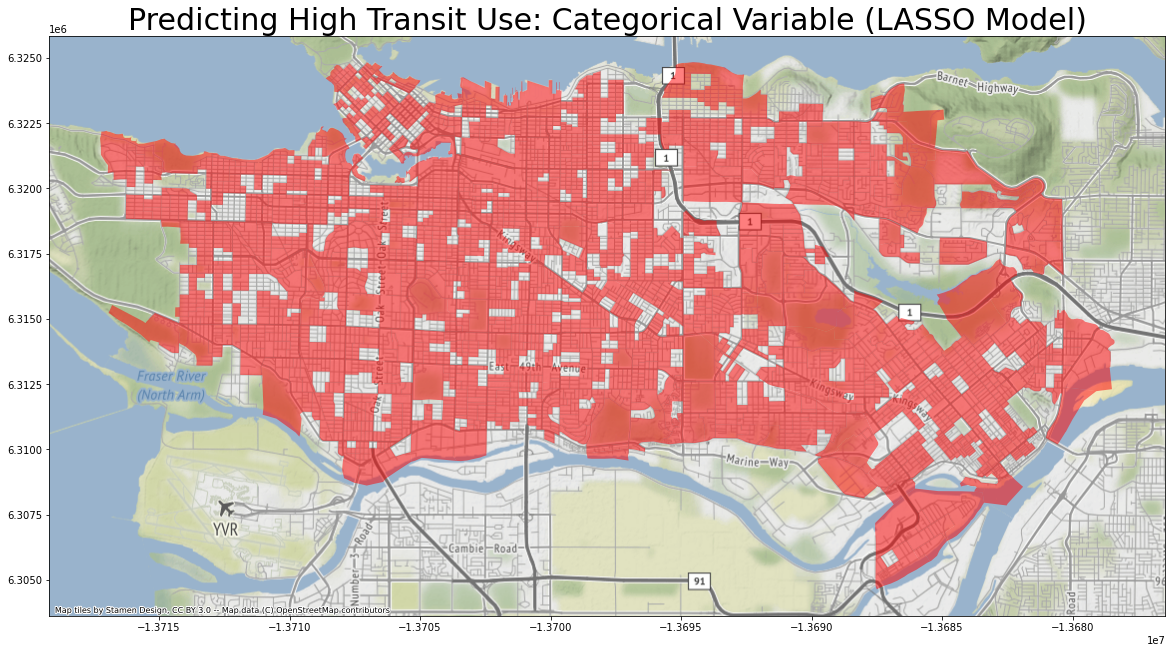

In [13]:
X_train_LASSO_top_categorical_mask = ((X_train.ADAUID == "59150117") 
                                      | (X_train.CCSUID == "5915022") 
                                      | (X_train.CCSUID == "5915025"))

X_train_LASSO_top_categorical = X_train.loc[X_train_LASSO_top_categorical_mask, :]

LASSO_top_categorical_ax = X_train_LASSO_top_categorical.plot(
    figsize=(20, 20),
    alpha=0.5,
    color="red"
)

ctx.add_basemap(LASSO_top_categorical_ax, zoom=12)
plt.title("Predicting High Transit Use: Categorical Variable (LASSO Model)", fontsize=30)

plt.savefig(
    os.path.join(
        os.getcwd(),
        "Vancouver_transit",
        "Maps",
        data_version,
        "LASSO_top_categorical.png",
    )
)

As shown in the map above, areas in the city of Vancouver tend to have high proportions of people using public transit. 

In [14]:
LASSO_categorical_feature_coeffs.sort_values("coeffs").head(5)

,feature,coeffs
70,ADAUID_59150035,-0.119335
74,ADAUID_59150040,-0.092524
76,ADAUID_59150042,-0.071774
69,ADAUID_59150034,-0.060664
313,ADAUID_59150312,-0.056735


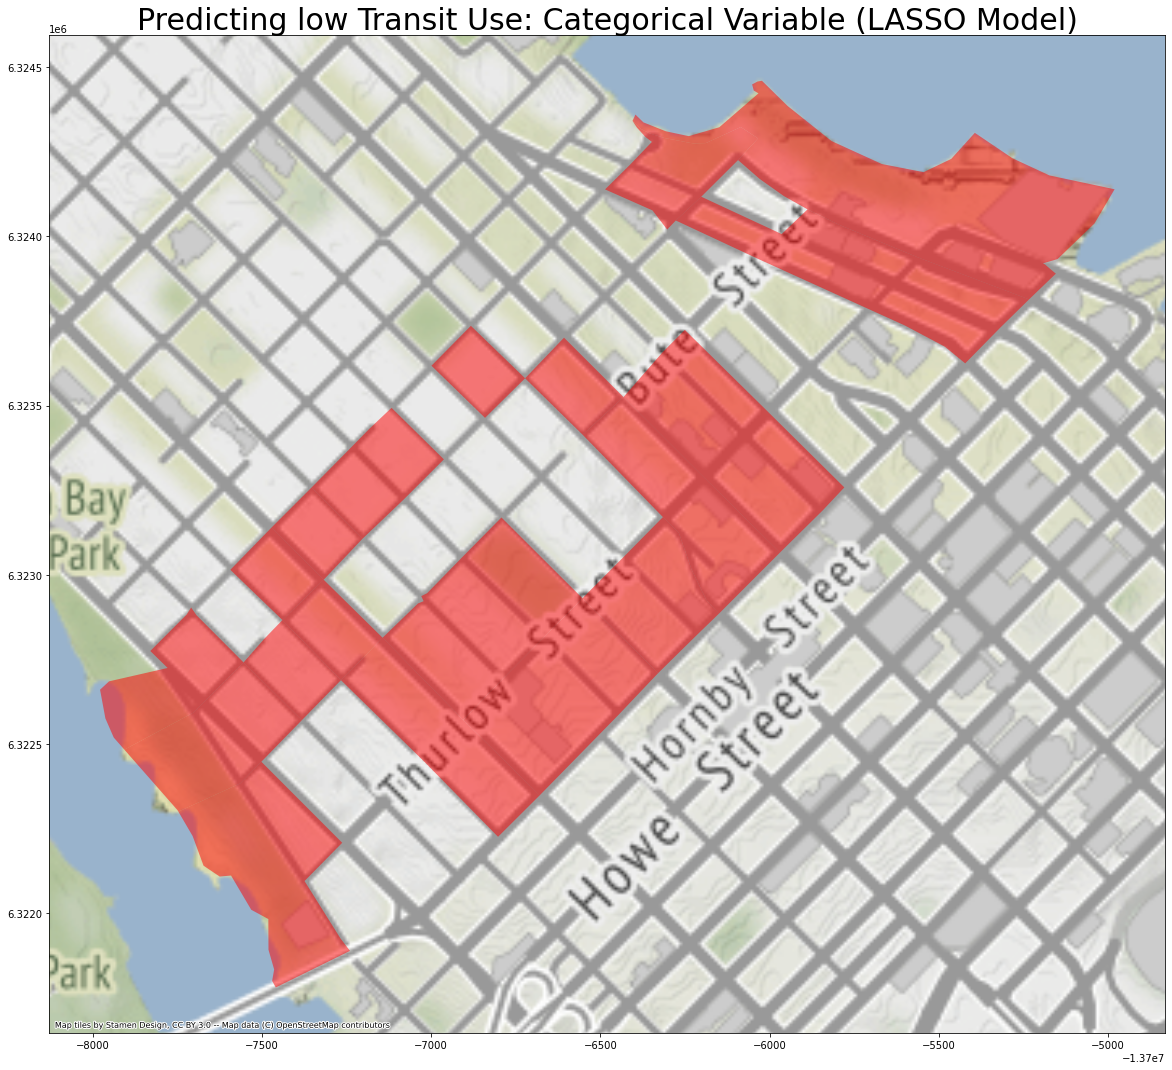

In [15]:
X_train_LASSO_bottom_categorical_mask = ((X_train.ADAUID == "59150035") 
                                      | (X_train.ADAUID == "59150040") 
                                      | (X_train.ADAUID == "59150042"))

X_train_LASSO_bottom_categorical = X_train.loc[X_train_LASSO_bottom_categorical_mask, :]

LASSO_bottom_categorical_ax = X_train_LASSO_bottom_categorical.plot(
    figsize=(20, 20),
    alpha=0.5,
    color="red"
)

ctx.add_basemap(LASSO_bottom_categorical_ax, zoom=14)
plt.title("Predicting low Transit Use: Categorical Variable (LASSO Model)", fontsize=30)

plt.savefig(
    os.path.join(
        os.getcwd(),
        "Vancouver_transit",
        "Maps",
        data_version,
        "LASSO_bottom_categorical.png",
    )
)

Somehow unexpectedly, areas that most strongly predict low public transit use are also in the downtown area. They are distributed along Thurlow Street. It is important they are also in the CCS which predicts high transit use. In other words, these areas may have lower transit use than their immediate neighbors, but not necessarily compared to other ares in GVA.  

#### Random Forest Model
The table below shows the five categorical features that mostly strongly impact proportion of transit use among residents. They are CSD or CCS areas. It is worth noting that we cannot know the direction of impact from these inpurity measures. 

In [16]:
#### Categorical features
rf_categorical_feature_imps = rf_immpurity_feat_imp_coeffs.loc[rf_immpurity_feat_imp_coeffs["feature"].isin(categorical_feature_names), :]
rf_categorical_feature_imps.sort_values("impurity_importance", ascending = False).head(5)

,feature,impurity_importance
18,CSDUID_5915022,0.008434
8,CCSUID_5915025,0.005865
2,CCSUID_5915001,0.004445
7,CCSUID_5915022,0.003664
148,ADAUID_59150117,0.001297


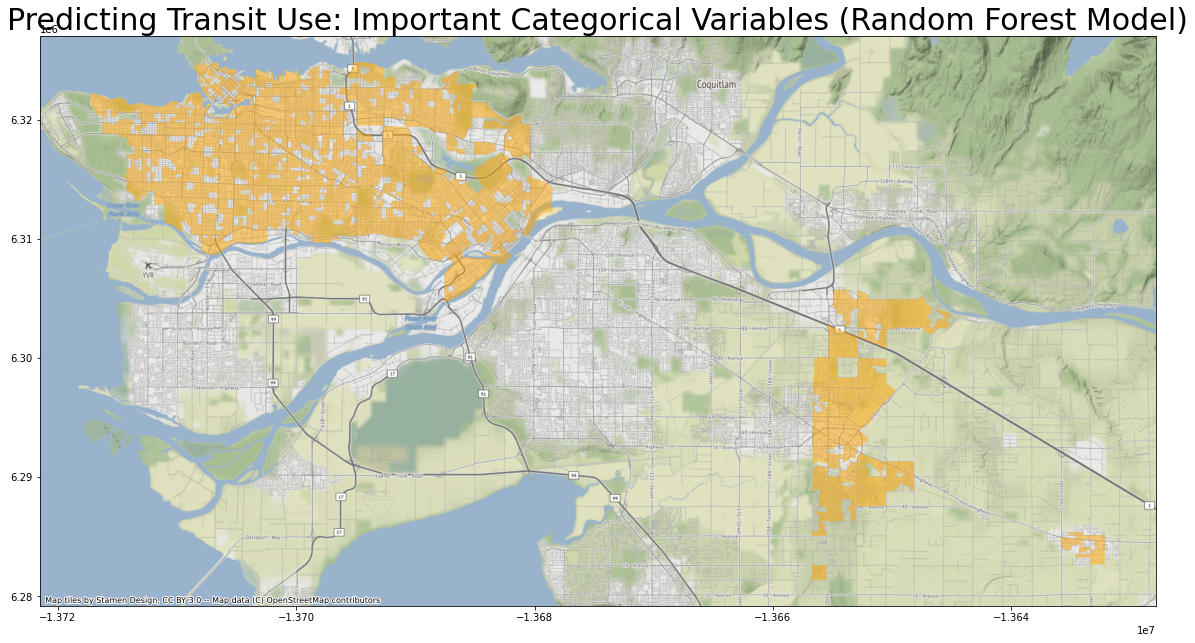

In [17]:
X_train_rf_imp_categorical_mask = ((X_train.CSDUID == "5915022") 
                                      | (X_train.CCSUID == "5915025") 
                                      | (X_train.CCSUID == "5915001"))

X_train_rf_imp_categorical = X_train.loc[X_train_rf_imp_categorical_mask, :]

rf_imp_categorical_ax = X_train_rf_imp_categorical.plot(
    figsize=(20, 20),
    alpha=0.5,
    color="orange"
)

ctx.add_basemap(rf_imp_categorical_ax, zoom=12)
plt.title("Predicting Transit Use: Important Categorical Variables (Random Forest Model)", fontsize=30)

plt.savefig(
    os.path.join(
        os.getcwd(),
        "Vancouver_transit",
        "Maps",
        data_version,
        "rf_imp_categorical.png",
    )
)

If we can take a guess, however, areas in the city of Vancouver probably tend to have higher rates of transit use. By contrast, The east part of Langley city and Aldergrove probably have low transit use. We will know more details about each feature's impact later using SHAP. 

### Numeric features

#### LASSO Model

In [19]:
#### LASSO Model
LASSO_numeric_feature_coeffs = LASSO_feature_coeffs.loc[LASSO_feature_coeffs["feature"].isin(numeric_feature_names), :].copy()
LASSO_numeric_feature_coeffs["explanation"] = list(map(lambda col_name: X_header[X_train.columns.get_loc(col_name)], LASSO_numeric_feature_coeffs["feature"]))

In [20]:
LASSO_numeric_feature_coeffs.sort_values("coeffs", ascending=False).head(5)

,feature,coeffs,explanation
620,vn289,0.022032,Immigration - Total Sex / Total - Age at immig...
711,vn380,0.021731,Labour - Total Sex / Participation rate
383,vn52,0.018865,Households - Both sexes / Total - Persons not ...
682,vn351,0.016852,Ethnic Origin - Total Sex / Total - Ethnic ori...
439,vn108,0.016713,Housing - Total Sex / Total - Owner and tenan...


In [21]:
for exp in LASSO_numeric_feature_coeffs.sort_values("coeffs", ascending=False).head(5).explanation:
    print(exp)

Immigration - Total Sex / Total - Age at immigration for the immigrant population in private households - 25% sample data / 25 to 44 years
Labour - Total Sex / Participation rate
Households - Both sexes / Total - Persons not in census families in private households - 100% data ; Both sexes
Ethnic Origin - Total Sex / Total - Ethnic origin for the population in private households - 25% sample data / European origins / British Isles origins
Housing - Total Sex / Total -  Owner and tenant households with household total income greater than zero, in non-farm, non-reserve private dwellings by shelter-cost-to-income ratio - 25% sample data / Spending less than 30% of income on shelter costs


As shown in the table and list above, important numeric factors that indicate strong transit use include: 

(1) Large of immigrant population who moved to Canada when they were 25 to 44 years old,

(2) High labor participation rate (number of people working as a percentage of total population),

(3) High number of people who do not live in families,

(4) High number of people of British ethnicity, and

(5) High number of people who spend less money on housing as compared to their income. 

In [25]:
LASSO_numeric_feature_coeffs.sort_values("coeffs", ascending=True).head(5)

,feature,coeffs,explanation
712,vn381,-0.016735,Labour - Total Sex / Employment rate
724,vn393,-0.015868,Labour - Total Sex / Total labour force aged 1...
790,vn479,-0.014384,Journey to Work - Males / Total - Commuting de...
448,vn117,-0.013827,Housing - Total Sex / Total - Owner households...
453,vn122,-0.013343,Housing - Total Sex / Total - Tenant household...


In [26]:
for exp in LASSO_numeric_feature_coeffs.sort_values("coeffs", ascending=True).head(5).explanation:
    print(exp)

Labour - Total Sex / Employment rate
Labour - Total Sex / Total labour force aged 15 years and over by class of worker - 25% sample data / All classes of workers / Self-employed
Journey to Work - Males / Total - Commuting destination for the employed labour force aged 15 years and over in private households with a usual place of work - 25% sample data / Commute within census subdivision (CSD) of residence
Housing - Total Sex / Total - Owner households in non-farm, non-reserve private dwellings - 25% sample data / Average value of dwellings ($)
Housing - Total Sex / Total - Tenant households in non-farm, non-reserve private dwellings - 25% sample data / Average monthly shelter costs for rented dwellings ($)


As shown in the table and list above, the following numeric features most strongly predict low transit use: 

(1) High employment rate (number of people actually employed as a percentage of people who want to be employed),

(2) Large self-employed population,

(3) Large number of people working in the same CSD,
 
(4) High average value of dwellings, and

(5) High average housing cost for rented dwellings. 

We would also be interested in knowing where the two variables that we are interested in rank among the numeric features. The answer is given below: 

In [45]:
rank_services_LASSO = list(LASSO_numeric_feature_coeffs.sort_values("coeffs", ascending=False)["feature"]).index("NBA_services_PC")

rank_stops_LASSO = list(LASSO_numeric_feature_coeffs.sort_values("coeffs", ascending=False)["feature"]).index("NBA_stops_PC")

print(f"Among {LASSO_numeric_feature_coeffs.shape[0]} numeric features, number of services percapita ranks {rank_services_LASSO}, and number of stops per capite ranks {rank_stops_LASSO}.")

Among 462 numeric features, number of services percapita ranks 20, and number of stops per capite ranks 128.


### Proportional features
#### LASSO Model

#### Random Forest model

In [29]:
#### Numeric features
rf_numeric_feature_imps = rf_immpurity_feat_imp_coeffs.loc[rf_immpurity_feat_imp_coeffs["feature"].isin(numeric_feature_names), :].copy()
rf_numeric_feature_imps["explanation"] = list(map(lambda col_name: X_header[X_train.columns.get_loc(col_name)], rf_numeric_feature_imps["feature"]))

In [31]:
rf_numeric_feature_imps.sort_values("impurity_importance", ascending=False).head(5)

,feature,impurity_importance,explanation
349,vn18,0.036776,Population and dwelling counts / Population de...
800,NBA_services_PC,0.019114,NBA_services_PC
548,vn217,0.006549,Income - Total Sex / Total - Income statistics...
352,vn21,0.004274,Dwelling characteristics / Total - Occupied pr...
415,vn84,0.003868,Housing - Total Sex / Total - Occupied private...


In [32]:
for exp in rf_numeric_feature_imps.sort_values("impurity_importance", ascending=False).head(5).explanation:
    print(exp)

Population and dwelling counts / Population density per square kilometre
NBA_services_PC
Income - Total Sex / Total - Income statistics in 2015 for the population aged 15 years and over in private households - 100% data / Number of government transfers recipients aged 15 years and over in private households - 100% data / Median government transfers in 2015 among recipients ($)
Dwelling characteristics / Total - Occupied private dwellings by structural type of dwelling - 100% data / Single-detached house
Housing - Total Sex / Total - Occupied private dwellings by period of construction - 25% sample data / 1960 or before


The table and list above show the important numeric features in our Random Forest model. Population density turns out to be the most important feature. 
Also, much to our pleasure, number of services per capita, the variable that we are interested in, ranks the second in terms of importance. 

Other important features include number of government transfer recipients, high number of single-detached house, and very house dwellings. 

In [24]:
## How I built the two models

As it is markdown, you can embed images, HTML, etc into your posts!

![](https://myst-parser.readthedocs.io/en/latest/_static/logo.png)

You an also $add_{math}$ and

$$
math^{blocks}
$$

or

$$
\begin{aligned}
\mbox{mean} la_{tex} \\ \\
math blocks
\end{aligned}
$$

But make sure you \$Escape \$your \$dollar signs \$you want to keep!

## MyST markdown

MyST markdown works in Jupyter Notebooks as well. For more information about MyST markdown, check
out [the MyST guide in Jupyter Book](https://jupyterbook.org/content/myst.html),
or see [the MyST markdown documentation](https://myst-parser.readthedocs.io/en/latest/).

## Code blocks and outputs

Jupyter Book will also embed your code blocks and output in your book.
For example, here's some sample Matplotlib code:

SyntaxError: invalid syntax (<ipython-input-24-bf889ce84af7>, line 3)

In [ ]:
from matplotlib import rcParams, cycler
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

In [ ]:
# Fixing random state for reproducibility
np.random.seed(19680801)

N = 10
data = [np.logspace(0, 1, 100) + np.random.randn(100) + ii for ii in range(N)]
data = np.array(data).T
cmap = plt.cm.coolwarm
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, N)))


from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(.5), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]

fig, ax = plt.subplots(figsize=(10, 5))
lines = ax.plot(data)
ax.legend(custom_lines, ['Cold', 'Medium', 'Hot']);

There is a lot more that you can do with outputs (such as including interactive outputs)
with your book. For more information about this, see [the Jupyter Book documentation](https://jupyterbook.org)